In [21]:
import snap
from snap import TUNGraph
import os
import sys
import operator
import pandas as pd
import subprocess
import numpy as np
import csv
from matplotlib import pyplot as plt
import seaborn as sns
from __future__ import print_function
from IPython.display import HTML, display
import tabulate

# Set Seaborn defaults
sns.set()
%matplotlib inline

# Global variables
data_dir = "../data"

# 0. Network Basic Properties
It's important to understand the core features of the network before digging into low-level analysis through expensive algorithms. From now on, we would be referring to the terminology listed below.

We already had obtained the number of nodes $N$ and the number of links $L$ from the previous notebooks, and these two information are enough to calculate the average degree $\langle K \rangle$ as $\langle K \rangle = \frac{2L}{N}$, since the network is ***undirected***.

In [2]:
# Calculate network average degree
N = 89577277
L = 434193958
K = 2.0 * L/N
print("Average Degree is %.3f" %K)

Average Degree is 9.694


| Number of nodes ($N$) | Number of links ($L$) | Average Degree $\langle K \rangle$ |
|---|---|---|
| 89.577.277 (~90M) | 434.193.958 (~400M) | 9,694 |

# 1. Generate undirected graph with SNAP.Py
Calculating the network metrics doesn't necessarily require including edge metadata in the graph, therefore **SNAP.Py** comes handy in this case. Let's import the MMR data in an **undirected graph** data structure and build the main network.

Since SNAP.Py allows inserting vertices by specifying a **node ID**, I don't need to read the `usernames.csv` file, since all IDs from 0 to $(N-1)$ are existing for sure, where $N=89.577.277$. By the other hand, I may read the edges from the `mmr_encoded_final.csv` file and ignore the edge metadata column including the periods array.

In [3]:
def read_large_file(file_object):
    while True:
        data = file_object.readline()
        if not data:
            break
        yield data.rstrip('\n')

# We ignore prop for the moment
def process_edge_line(line):
    source, target, prop = line.split(',')
    return int(source), int(target)

def build_mmr_graph():
    # Create main graph object
    graph = TUNGraph.New()

    # First add vertices
    print("Adding vertices...")
    for i in xrange(0, N):
        graph.AddNode(i)
    print("Done adding vertices, now adding links...")

    # Add links by reading them from MMR data file
    with open(os.path.join(data_dir,"mmr_encoded_final.csv")) as io:
        counter = 0
        for line in read_large_file(io):
            source, target = process_edge_line(line)
            graph.AddEdge(source, target)
            counter += 1
            if counter % 50000000 == 0:
                print("Added %d links..." %counter)
        print("Done! Total links: %d" %counter)
        assert counter == L
    return graph

In [5]:
%%time
graph = build_mmr_graph()

Adding vertices...
Done adding vertices, now adding links...
Added 50000000 links...
Added 100000000 links...
Added 150000000 links...
Added 200000000 links...
Added 250000000 links...
Added 300000000 links...
Added 350000000 links...
Added 400000000 links...
Done! Total links: 434193958
CPU times: user 29min 20s, sys: 13.9 s, total: 29min 34s
Wall time: 29min 31s


Building the whole MMR graph takes ~30 minutes, which is quite reasonable. Let's check how much is the currently consumed memory:

In [6]:
%%bash
free -h

              total        used        free      shared  buff/cache   available
Mem:           125G         16G         13G        102M         95G        108G
Swap:           63G        232M         63G


The whole graph loaded in memory takes *less than 16GB* of RAM, which is significantly uncomparable with NetworkX's performance.

# 2. Degree Distribution and Node Degrees
SNAP.Py comes with a built-in function to calculate the histogram values needed to plot the degree distribution. The output variable, `DegToCntV`, is a vector of pairs such that the first element indicates the $x$-axis value ($k$ = degree), and the second one the $y$-axis value (number of degree-$k$ nodes). In order to represent $p_k$, which is a probability hence whose values range in the interval $[0,1]$, I have to normalize it: $p_k=\frac{N_k}{N}$, where $N_k$ is the number of degree-$k$ nodes.

The degree distribution represents a core feature for network analysis, because it explains what is the probability $p_k$ that, given a random node, it has degree $k$. Furthermore, $p_k$ determines many network phenomena such as network robustness.

In [7]:
%%time

def calculate_degree_distribution(graph):
    DegToCntV = snap.TIntPrV()
    snap.GetDegCnt(graph, DegToCntV)
    return DegToCntV

DegToCntV = calculate_degree_distribution(graph)

CPU times: user 1.96 s, sys: 0 ns, total: 1.96 s
Wall time: 1.96 s


Execution time above points out the impressive performance of SNAP.Py even with large-scale networks over Neo4j and NetworkX.

I hereby plot the degree distribution both in regular scale and logarithmic scale.

In [26]:
x = [item.GetVal1() for item in DegToCntV]
y = [item.GetVal2() * 1.0 / N for item in DegToCntV]

In [33]:
print("Min Degree: %d\nMax Degree: %d\n" %(min(x), max(x)))
print("Min p(k): %.15f\nMax p(k): %.15f" %(min(y), max(y)))

Min Degree: 1
Max Degree: 41359

Min p(k): 0.000000011163545
Max p(k): 0.326320502017493


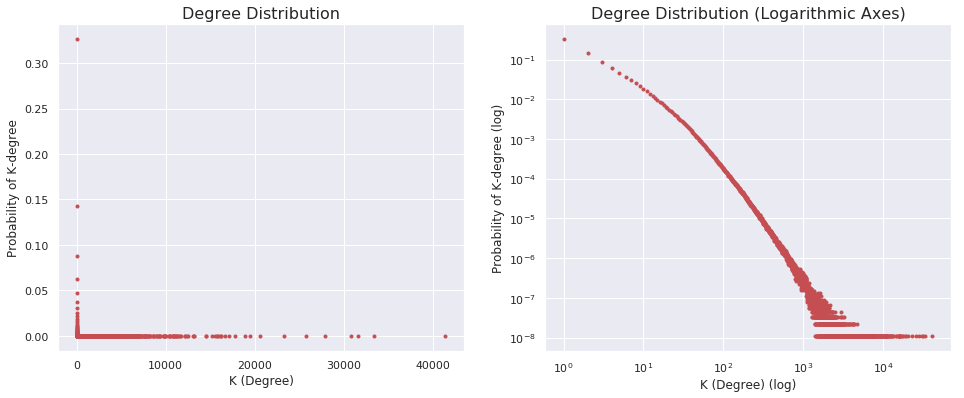

In [17]:
plt.figure(figsize=(16,6))

# First subplot: normal axes
plt.subplot(1,2,1)
plt.xlabel("K (Degree)")
plt.ylabel("Probability of K-degree")
plt.plot(x,y,"r.")
plt.title("Degree Distribution", fontsize=16)

# Second subplot: logarithmic axes
plt.subplot(1,2,2)
plt.xlabel("K (Degree) (log)")
plt.ylabel("Probability of K-degree (log)")
plt.loglog(x, y, "r.")
plt.title("Degree Distribution (Logarithmic Axes)", fontsize=16)

# Show figure
plt.show()

At first sight, the distribution plotted with regular scale doesn't seem very meaningful, and the reason is easily arguable: our MMR graph has nodes whose degrees range in $1 \leq k \leq 41359$, whereas the values of the probability range in $0 \lt p_k \leq 0.326$. By looking at the plot, it's easy to infer that more than 1/3 of the nodes have only one link, and the probability of having more than one link decreases exponentially. Here the logarithmic scale becomes convenient, because it better highlights this phenomenon which is typical of those networks known as ***scale-free networks***. A scale-free network, indeed, is defined as such when its degree distribution follows (at least asymptotically) a **power law**.

## 2.1 Usernames with highest $k$
I wanted to investigate which Twitter usernames actually correspond to those nodes with extremely high degree.

In [35]:
n_id_max_deg = snap.GetMxDegNId(graph)
print("The node with the highest degree has ID %d" %n_id_max_deg)

The node with the highest degree has ID 54790022


In [77]:
%%bash
../scripts/get_username.sh 54790022

cocanomc,54790022


SNAP.Py comes with a built-in function to calculate the In/Out degree of every node in the graph (`GetNodeInDegV` / `GetNodeOutDegV`). Since our graph is undirected, any function would suit fine.

In [36]:
%%time

InDegV = snap.TIntPrV()
snap.GetNodeInDegV(graph, InDegV)
node_degrees = [(item.GetVal1(), item.GetVal2()) for item in InDegV]

# Sort list by degree
node_degrees = sorted(node_degrees, key=operator.itemgetter(1))

CPU times: user 3min 25s, sys: 9.43 s, total: 3min 34s
Wall time: 3min 28s


Let's show who are the top 20 nodes with the highest degree and try to figure out if any of them correspond to any well known Twitter username. The previously created `get_username.sh` bash script is convenient when I need to lookup for a single value, but running it several times might be time consuming. Hereby the function that should be preferred when multiple lookups are needed:

In [141]:
# %load ../scripts/def_get_multiple_usernames.py
def get_multiple_usernames(ids):
    # Convert ID to line number by adding 1
    arg = ";".join([str(el + 1) + "p" for el in ids])

    #Invoke shell script that finds the occurrences
    p = subprocess.Popen(['../scripts/get_usernames.sh', arg], stdout=subprocess.PIPE)
    output = p.communicate()[0]

    id_to_username_dict = {line.split(',')[1]:line.split(',')[0] for line in output.split('\n') if line != ""}
    return id_to_username_dict

In [150]:
%%time
data = sorted(node_degrees[-20:], key=operator.itemgetter(1), reverse=True)
node_ids = [el[0] for el in data]
id_to_username_dict = get_multiple_usernames(node_ids)

CPU times: user 0 ns, sys: 392 ms, total: 392 ms
Wall time: 15.7 s


In [210]:
def show_data_as_dataframe(data, column_labels):
    df = pd.DataFrame(data, columns=column_labels)
    display(df)
    return df

In [151]:
# Show data formatted as DataFrame
data = [[id_to_username_dict[str(el[0])], el[0], el[1]] for el in data]
show_data_as_dataframe(data, ["Username", "Node ID (Encoding)", "Degree"])

,Username,Node ID (Encoding),Degree
0,cocanomc,54790022,41359
1,telkomsel,61888,33341
2,stccare,272020,31578
3,virginmedia,113519,30738
4,xboxsupport,112622,27853
5,americanair,38831,25676
6,atviassist,13925,23270
7,tesco,34364,20606
8,btcare,46286,19399
9,indosatcare,64396,18911


The results shown above show one of the first issues with the collected data, since it was not subject to any data-cleaning process before the analysis. By individually checking all the Twitter usernames listed above, it's easy to infer that they all correspond to famous, large-scale companies that use Twitter as a social media platform to get in touch with their customers, often through *customer technical support* inquiries. This explains their huge degree value (as of now, they're basically **network hubs**), but at the same times it represents a downside for our analysis since their connections are more likely not to be very meaningful.

Mutual relationships between such companies and the users ideally won't be featured by any controversial/partisan dispute or particular ideology represented by the hashtags I'll be investigating on. Therefore, the most intuitive step to acknowledge is *getting rid of them*. However, this shouldn't actually be limited only to the top 20 users with top degree, but to all potential users that fall within the category identified above.

It's better and cleaner to keep the data cleanup process in a separate notebook, therefore I could just dump the *node degrees* from the current notebook to a file and re-use it from the new notebook:

In [241]:
with open("../data/temp/node_degrees.csv", "w") as out:
    for el in node_degrees:
        out.write(",".join([str(el[0]), str(el[1])]) + "\n")

# 3. Data Cleanup: Removing Corporates' Customer Service Twitter accounts
The Internet provided me with a convenient yet not properly structured and incomplete [list of Twitter Corporate Accounts](https://gist.github.com/mbejda/45db05ea50e79bc42016#file-fortune-1000-company-twitter-accounts-csv), that could help me instantly figure out which Twitter usernames actually belong to a company and not a private user. I cleaned up the original CSV file, came up with a list of 428 Twitter corporate usernames and created a new bash script `find_companies_usernames.sh` to actually check which corporate accounts are included in our data:
~~~bash
while IFS= read -r h
do
    egrep "^$h," -i -m 1 "$2" | tee -a ../data/found_companies.csv
done < "$1"
~~~
Therefore I ran the script with:
~~~bash
./find_companies_usernames.sh /path/to/twitter_companies.txt /path/to/usernames.csv
~~~
and got the `found_companies.csv` output file with **366 entries**. Since the provided input list is not meant to be a full extensive list of *all* Twitter corporate accounts, there's still a lot of unwanted data that could be cleaned up. By looking at the top 20 nodes with highest degree shown before, I could easily point out that common username patterns are `*support`, `*care` or `*help` (e.g. `stccare`, `xboxsupport`, `amazonhelp` etc.). Therefore, I could further expand my check by identifying those usernames that match these patterns. In order to achieve this, I include these statements in the `find_companies_usernames.sh` script:
~~~bash
egrep ".*care,|.*support,|.*help," /path/to/usernames.csv | tee -a ../data/found_companies.csv
sort -u /path/to/found_companies.csv > /path/to/found_companies_nodup.csv # Remove duplicates
~~~
There are **14031** accounts that fall within this category, so I include them in the `found_companies.csv` file.

Now that I have a list of *14375 potential* corporate accounts I can state which ones actually represent noise in our data by checking their degree: if this is significantly high, let's say $k \gt 1000 \simeq 100*\langle K \rangle$, then I can conclude the concerned accounts should be filtered out.

**Warning**: the simple criteria that takes into consideration the name pattern and the degree of a node isn't necessarily sufficient to guarantee a 100\% match for a corporate account, although I do consider this trade-off pretty reasonable. The main drawback is excluding from the analysis a (relatively low) number of accounts that are reported as false positives; on the other hand, I would still not be able to detect *all* corporate accounts, because of the degree threshold limitation. Lowering the threshold too much would mean capturing more corporate accounts and at the same time more false positives.

In [204]:
%%bash --out shell_output
# Get only the IDs to work on in Python
awk -F "," '{print $2}' ../data/found_companies_nodup.csv

In [205]:
companies_ids = [int(el) for el in shell_output.split('\n') if el != '']

In [206]:
high_degrees = sorted([el for el in node_degrees if el[1] > 10*K], key=operator.itemgetter(1), reverse=True)

In [207]:
# Extract subset of node_degrees
companies_accounts_degrees = [el for el in high_degrees if el[0] in companies_ids]

In [208]:
node_ids = [el[0] for el in companies_accounts_degrees]
id_to_username_dict = get_multiple_usernames(node_ids)

# Show data formatted as DataFrame
data = [[id_to_username_dict[str(el[0])], el[0], el[1]] for el in companies_accounts_degrees]
show_data_as_dataframe(data, ["Username", "Node ID (Encoding)", "Degree"])

,Username,Node ID (Encoding),Degree
0,stccare,272020,31578
1,xboxsupport,112622,27853
2,americanair,38831,25676
3,btcare,46286,19399
4,indosatcare,64396,18911
5,amazonhelp,5513254,17815
6,telkomcare,735473,16169
7,tmobilehelp,247443,13218
8,vzwsupport,18919,12211
9,sprintcare,33051,11278


In [218]:
# Test check
node_degrees_temp = node_degrees[:]
node_degrees_temp = list(set(node_degrees_temp) - set(companies_accounts_degrees))
len(node_degrees_temp)

89576661

In [226]:
node_degrees_temp = sorted(node_degrees_temp, key=operator.itemgetter(1), reverse=True)

In [230]:
pd.set_option('display.max_rows', 1000)
data = node_degrees_temp[:1000]
node_ids = [el[0] for el in data]
id_to_username_dict = get_multiple_usernames(node_ids)

# Show data formatted as DataFrame
data = [[id_to_username_dict[str(el[0])], el[0], el[1]] for el in data]
df = show_data_as_dataframe(data, ["Username", "Node ID (Encoding)", "Degree"])

,Username,Node ID (Encoding),Degree
0,cocanomc,54790022,41359
1,telkomsel,61888,33341
2,virginmedia,113519,30738
3,atviassist,13925,23270
4,tesco,34364,20606
5,erpestar,59012597,17097
6,tacobell,667666,16651
7,movistararg,13932,16205
8,alphabetsuccess,368890,15918
9,ee,219882,15770


# 4. Connected Components

In [154]:
ComponentDist = snap.TIntPrV()
snap.GetSccSzCnt(graph, ComponentDist)
for comp in ComponentDist:
    print("Size: %d - Number of Components: %d" % (comp.GetVal1(), comp.GetVal2()))

Size: 2 - Number of Components: 1736460
Size: 3 - Number of Components: 199996
Size: 4 - Number of Components: 48135
Size: 5 - Number of Components: 16107
Size: 6 - Number of Components: 7011
Size: 7 - Number of Components: 3303
Size: 8 - Number of Components: 1967
Size: 9 - Number of Components: 1285
Size: 10 - Number of Components: 984
Size: 11 - Number of Components: 750
Size: 12 - Number of Components: 570
Size: 13 - Number of Components: 452
Size: 14 - Number of Components: 358
Size: 15 - Number of Components: 317
Size: 16 - Number of Components: 256
Size: 17 - Number of Components: 184
Size: 18 - Number of Components: 152
Size: 19 - Number of Components: 134
Size: 20 - Number of Components: 132
Size: 21 - Number of Components: 108
Size: 22 - Number of Components: 95
Size: 23 - Number of Components: 96
Size: 24 - Number of Components: 70
Size: 25 - Number of Components: 78
Size: 26 - Number of Components: 79
Size: 27 - Number of Components: 65
Size: 28 - Number of Components: 65
S